In [1]:
import os
import tweepy as tw
import pandas as pd

# Para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
import plotly.express as px

# Para procesar el texto
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
import itertools
import collections
from googletrans import Translator

# Para vectorizar el texto
from sklearn.feature_extraction.text import CountVectorizer

APP_KEY = "UWL7qvlRIdI6EfbowPk4XFSei"
APP_SECRET = "ShFsXQ0zFowgKpMAswsls1QBXnXPoT9W6IYXUVar5RX7M0Ko75"
OAUTH_TOKEN = "1202759753996423168-tksZBrdrGiIsS8sKPjdI4BwH165Ku2"
OAUTH_TOKEN_SECRET = "xp20Ij7NgHXXxqsdt3QcSTe22Mo5BJjUyKhUuT7eHH9tq"
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAOz8mgEAAAAAENt%2FX8aOznG6OZ4zyBgEnrPW7Xg%3DeIUN3P11eGb7u89luyFTYA2ZAWsNQDeMkVAXEbeMVaE6V9tg64"

auth = tw.OAuthHandler(APP_KEY, APP_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tw.API(auth, wait_on_rate_limit=True)

# Parámetros de búsqueda
search_words = "turismo inclusivo"

new_search = f"{search_words}"  # lang:es
new_search

tweets = tw.Cursor(
    api.search_tweets,
    q=search_words,
    # lang="es",
    # since=date_since
    place_id="0639360bd49a15e3",
    tweet_mode="extended",
).items(1500)

tweets_list = [[tweet.full_text, tweet.user.id] for tweet in tweets]
tweets_list

tweet_df = pd.DataFrame(
    data=tweets_list,
    columns=[
        "tweet",
        "id",
    ],
)
tweet_df.head()

tweet_df.to_csv("tweets_Semillero.csv")


Bad key savefig.frameon in file c:\Users\Juan Barrios\anaconda3\envs\curso_nlp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file c:\Users\Juan Barrios\anaconda3\envs\curso_nlp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file c:\Users\Juan Barrios\anaconda3\envs\curso_nlp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("tweets_Semillero.csv", sep='\t')
df.head()

,",tweet,id"
0,"0,""En la Secretaría de Turismo de Guerrero est..."
1,"1,Turismo Accesible e Inclusivo para todas las..."
2,"2,""RT @BarcelonaInfoES: Seguimos apostando por..."
3,"3,RT @cubadebatecu: 🤥🔄📲 El Grupo de Turismo Ga..."
4,"4,RT @cubadebatecu: 🤥🔄📲 El Grupo de Turismo Ga..."


Análisis basados en frecuencias


In [3]:
def process(txt):
    txt = " ".join(txt.lower().split())
    txt = " ".join(re.sub(r"http\S+", "", txt).split())  # URLs
    txt = " ".join(re.sub(r"@[\w_]+", "", txt).split())  # @-Mención
    txt = " ".join(re.sub(r"\#+[\w_]+[\w\'_\-]*[\w_]+", "", txt).split())  # Hash-tags
    return txt.translate(str.maketrans("", "", string.punctuation))

In [4]:
def top_n_words(lista, n=None, grafico=True, titulo="Título"):
    vec = CountVectorizer().fit(lista)
    bag_of_words = vec.transform(lista)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    df2 = pd.DataFrame(words_freq, columns=["texto", "cantidad"])
    df2["%"] = df2["cantidad"] / len(lista) * 100
    if grafico:
        fig = px.bar(
            df2.head(n),
            x="texto",
            y="cantidad",
            title="{}".format(titulo),
            labels={"texto": "Palabras", "y": "cantidad"},
            color="cantidad",
        )
        fig.show()
    return df2.head(n)

In [5]:
def sentimiento(lista, titulo=""):
    df2 = pd.DataFrame({"sentimiento": lista})
    df2 = df2[df2.sentimiento != 0]
    fig = px.histogram(
        df2,
        x="sentimiento",
        histnorm="",  # Puede ser 'percent'
        title="Distribución de Polaridad - " + titulo,
        labels={"sentimiento": titulo, "y": "Porcentaje"},
        marginal="violin",
    )  # puede ser `rug`, `box`)
    fig.show()

In [6]:
def top_n_bigramas(lista, n=None, grafico=True, titulo="Título"):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(lista)
    bag_of_words = vec.transform(lista)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    df2 = pd.DataFrame(words_freq, columns=["texto", "cantidad"])
    df2["%"] = df2["cantidad"] / len(lista) * 100
    if grafico:
        fig = px.bar(
            df2.head(n),
            x="texto",
            y="cantidad",
            title="Bigramas – {}".format(titulo),
            labels={"texto": "Palabras", "y": "cantidad"},
            color="cantidad",
        )
        fig.show()
    return df2.head(n)

Limpieza de los Tweets

In [7]:
# Eliminamos tweets repetidos
tweet_df.drop_duplicates(subset=['tweet'], inplace=True)

In [8]:
# Empezamos a limpiar un poco el texto
all_tweets_no_urls = [process(tweet) for tweet in tweet_df.tweet]
all_tweets_no_urls[:10]

['en la secretaría de turismo de guerrero estamos comprometidos en promover el turismo con un enfoque inclusivo y respetuoso de los derechos humanos por eso nuestro titular santos ramírez cuevas se reunió con representantes de la comisión de los derechos humanos del estado',
 'turismo accesible e inclusivo para todas las personas',
 'rt  seguimos apostando por el turismo inclusivo y accesible ahora con la ruta easy walking tour para personas con movilid…',
 'rt  🤥🔄📲 el grupo de turismo gaviota desmintió los rumores que circulan en redes sociales sobre la limitación de entrada de cl…',
 'health tourisme turismo de salud turismo inclusivo turismo de recuperación estos son los grandes retos que los tour operadores desean realizar en las islas canarias y fuerteventura en particular nuestro personal nuestra dirección estratégica también…',
 '¿qué medidas crees que son fundamentales para lograr un turismo realmente inclusivo',
 'rt  📣trabajo colaborativo entre sernatur y  para desarrollar in

In [9]:
all_tweets_no_urls[0].split()
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[0]

['en',
 'la',
 'secretaría',
 'de',
 'turismo',
 'de',
 'guerrero',
 'estamos',
 'comprometidos',
 'en',
 'promover',
 'el',
 'turismo',
 'con',
 'un',
 'enfoque',
 'inclusivo',
 'y',
 'respetuoso',
 'de',
 'los',
 'derechos',
 'humanos',
 'por',
 'eso',
 'nuestro',
 'titular',
 'santos',
 'ramírez',
 'cuevas',
 'se',
 'reunió',
 'con',
 'representantes',
 'de',
 'la',
 'comisión',
 'de',
 'los',
 'derechos',
 'humanos',
 'del',
 'estado']

In [10]:
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Crea contador
counts_no_urls = collections.Counter(all_words_no_urls)

# counts_no_urls.most_common(15)
clean_tweets_no_urls = pd.DataFrame(
    counts_no_urls.most_common(15), columns=["palabras", "cantidad"]
)

clean_tweets_no_urls.head(10)

,palabras,cantidad
0,de,83
1,turismo,50
2,inclusivo,41
3,la,40
4,y,37
5,en,35
6,el,35
7,que,29
8,con,23
9,e,23


In [11]:
top_n_words(
    all_tweets_no_urls,
    n=10,
    grafico=True,
    titulo="Palabras comunes que se encuentran en los tweets (incluidas todas las palabras)",
)

,texto,cantidad,%
0,de,83,138.333333
1,turismo,52,86.666667
2,inclusivo,43,71.666667
3,la,40,66.666667
4,en,36,60.000000
5,el,35,58.333333
6,que,29,48.333333
7,con,23,38.333333
8,rt,20,33.333333
9,para,19,31.666667


Remover StopWords

In [12]:
import nltk

nltk.download("stopwords")

stop_words = set(stopwords.words("spanish"))

# Ver algunas palabras del conjunto
list(stop_words)[0:10]

[nltk_data] Downloading package stopwords to C:\Users\Juan
[nltk_data]     Barrios\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['tenías',
 'sentidos',
 'le',
 'hubiese',
 'esa',
 'algunas',
 'habías',
 'hubieran',
 'desde',
 'estuvieron']

In [13]:
words_in_tweet[0]

['en',
 'la',
 'secretaría',
 'de',
 'turismo',
 'de',
 'guerrero',
 'estamos',
 'comprometidos',
 'en',
 'promover',
 'el',
 'turismo',
 'con',
 'un',
 'enfoque',
 'inclusivo',
 'y',
 'respetuoso',
 'de',
 'los',
 'derechos',
 'humanos',
 'por',
 'eso',
 'nuestro',
 'titular',
 'santos',
 'ramírez',
 'cuevas',
 'se',
 'reunió',
 'con',
 'representantes',
 'de',
 'la',
 'comisión',
 'de',
 'los',
 'derechos',
 'humanos',
 'del',
 'estado']

In [14]:
tweets_nsw = [
    [word for word in tweet_words if not word in stop_words and len(word) > 2]
    for tweet_words in words_in_tweet
]

tweets_nsw[0]

['secretaría',
 'turismo',
 'guerrero',
 'comprometidos',
 'promover',
 'turismo',
 'enfoque',
 'inclusivo',
 'respetuoso',
 'derechos',
 'humanos',
 'titular',
 'santos',
 'ramírez',
 'cuevas',
 'reunió',
 'representantes',
 'comisión',
 'derechos',
 'humanos']

In [15]:
# Volvemos a revisar el grafico sin stopwords
tweets_ss = [" ".join(tweet_ss) for tweet_ss in tweets_nsw]
top_n_words(
    tweets_ss, n=10, grafico=True, titulo="Palabras comunes en tweets (sin stopwords)"
)

,texto,cantidad,%
0,turismo,52,86.666667
1,inclusivo,43,71.666667
2,personas,10,16.666667
3,accesible,8,13.333333
4,sociales,7,11.666667
5,grupo,6,10.000000
6,gaviota,6,10.000000
7,rumores,6,10.000000
8,redes,6,10.000000
9,sostenible,6,10.000000


In [16]:
collection_words = ['rt', 'turismo', 'inclusivo']

In [17]:
tweets_nsw_nc = [[w for w in word if not w in collection_words] for word in tweets_nsw]

In [18]:
tweets_ss_nc = [" ".join(tweet_ssc) for tweet_ssc in tweets_nsw_nc]
top_n_words(
    tweets_ss_nc,
    n=10,
    grafico=True,
    titulo="Palabras comunes en tweets (sin stopwords o custom_dict.)",
)

,texto,cantidad,%
0,personas,10,16.666667
1,accesible,8,13.333333
2,sociales,7,11.666667
3,grupo,6,10.000000
4,gaviota,6,10.000000
5,rumores,6,10.000000
6,redes,6,10.000000
7,sostenible,6,10.000000
8,tour,5,8.333333
9,circulan,5,8.333333


Bigramas


In [19]:
# Crear lista de listas que contienen bigrams en tweets
terms_bigram = [bigrams(tweet) for tweet in tweets_nsw_nc]

# Ver bigrams para el primer tweet
terms_bigram[0]

<generator object bigrams at 0x0000019C8376D548>

In [20]:
tweets_list[0]

['En la Secretaría de Turismo de Guerrero estamos comprometidos en promover el turismo con un enfoque inclusivo y respetuoso de los derechos humanos. Por eso, nuestro titular, Santos Ramírez Cuevas, se reunió con  representantes de la Comisión de los Derechos Humanos del Estado. https://t.co/DcKpxqOpgu',
 1022614028]

In [21]:
# Aplanar lista de bigrams en tweets limpios
bigrams = list(itertools.chain(*terms_bigram))

# Crear contador de palabras en bigramas limpios
bigram_counts = collections.Counter(bigrams)

# bigram_counts.most_common(20)
bigram_df = pd.DataFrame(bigram_counts.most_common(20), columns=["bigram", "count"])

bigram_df.head()

RuntimeError: generator raised StopIteration

In [ ]:
tweets_ss_nc = [" ".join(tweet_ssc) for tweet_ssc in tweets_nsw_nc]
top_n_bigramas(
    tweets_ss_nc,
    n=10,
    grafico=True,
    titulo="Palabras comunes en tweets (sin stopwords o custom_dict.)",
)

,texto,cantidad,%
0,rumores circulan,5,8.474576
1,circulan redes,5,8.474576
2,redes sociales,5,8.474576
3,desmintió rumores,4,6.779661
4,grupo gaviota,3,5.084746
5,gaviota desmintió,3,5.084746
6,sociales limitación,3,5.084746
7,reafirma compromiso,3,5.084746
8,atención emprendedoras,3,5.084746
9,debe ser,3,5.084746


Visualización redes de Bigramas

In [ ]:
# Crea un diccionario de bigramas y sus recuentos.
d = bigram_df.set_index("bigram").T.to_dict("records")

NameError: name 'bigram_df' is not defined

In [ ]:
# Crear red
G = nx.Graph()

# Crea conexiones entre nodos
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(
    G,
    pos,
    font_size=16,
    width=3,
    edge_color="grey",
    node_color="purple",
    with_labels=False,
    ax=ax,
)

# Crea etiquetas
for key, value in pos.items():
    x, y = value[0] + 0.135, value[1] + 0.045
    ax.text(
        x,
        y,
        s=key,
        bbox=dict(facecolor="red", alpha=0.25),
        horizontalalignment="center",
        fontsize=13,
    )

plt.show()

NameError: name 'd' is not defined

Nube de palabras

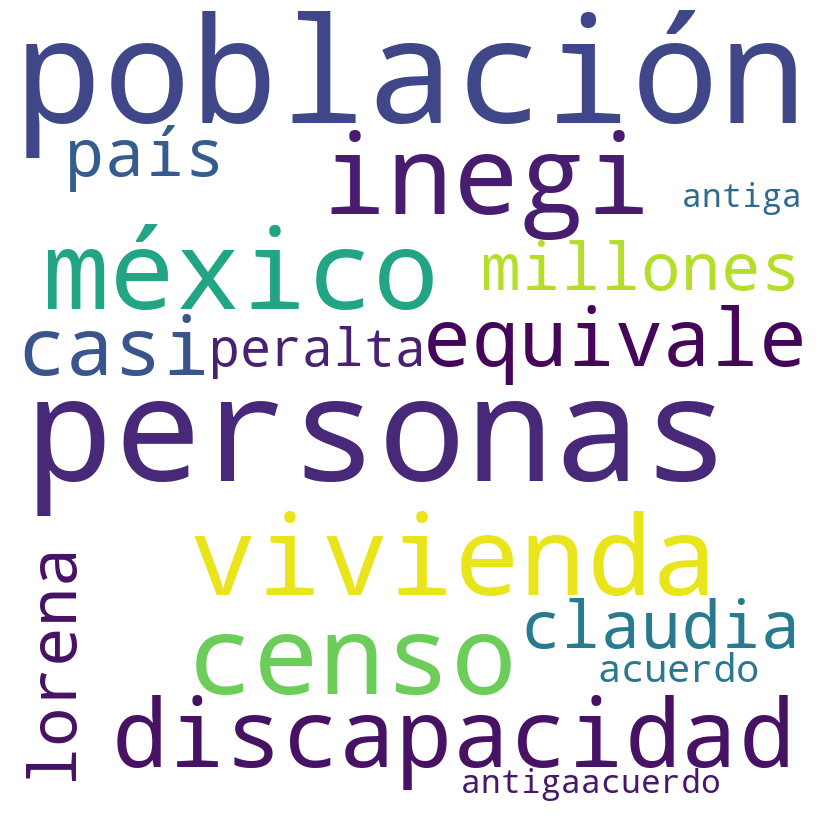

In [ ]:
# Nube de palabras
for Palabras in tweets_ss_nc:
    Palabras += str(Palabras + " ")

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",  #'black',
    max_words=100,
    min_font_size=10,
).generate(Palabras)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)  # , interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Modelo Pre-Entrenado

In [ ]:
sid = SentimentIntensityAnalyzer()
translator = Translator() # Traductor de Google

In [ ]:
tweets = [" ".join(word) for word in words_in_tweet]
tweet_df = pd.DataFrame(
    data=tweets,
    columns=[
        "tweet",
    ],
)
tweet_df.head()

,tweet
0,turismo accesible e inclusivo para todas las p...
1,rt seguimos apostando por el turismo inclusivo...
2,rt 🤥🔄📲 el grupo de turismo gaviota desmintió l...
3,health tourisme turismo de salud turismo inclu...
4,¿qué medidas crees que son fundamentales para ...


In [ ]:
tweet_df["translation"] = tweet_df["tweet"].apply(
    lambda x: translator.translate(x, dest="es").text
)
tweet_df["score"] = tweet_df["translation"].apply(
    lambda x: sid.polarity_scores(x)["compound"]
)
tweet_df["sentimiento"] = tweet_df["score"].apply(lambda x: "pos" if x >= 0 else "neg")
tweet_df.drop(columns=["translation"], inplace=True)
tweet_df.head()

TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [ ]:
sns.countplot(tweet_df.sentimiento)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'sentimiento'